<a href="https://colab.research.google.com/github/Pravallika-02-datascience/Time-series-Project/blob/main/Time_Series_Forecasting_using_ARIMA_and_Prophet_on_Airline_Passenger_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

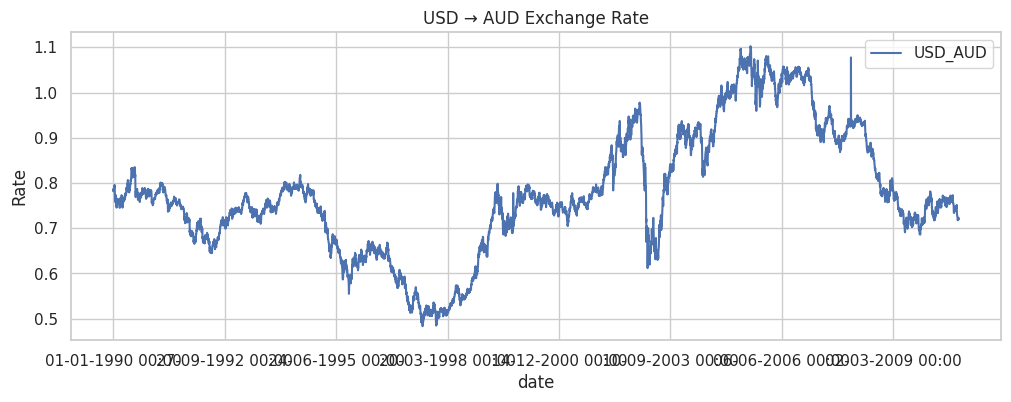

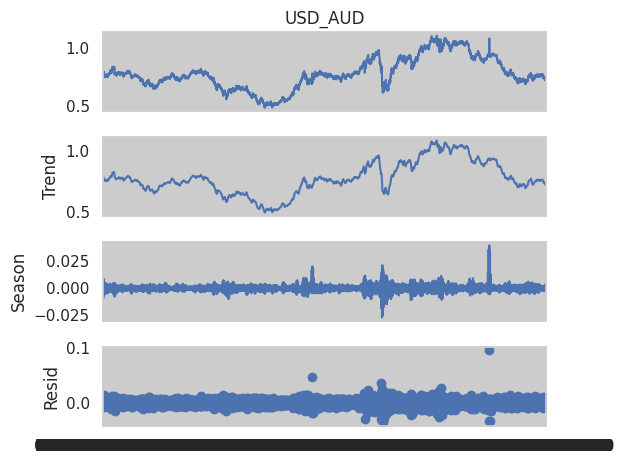

Missing values: 0
ADF p‑value: 0.4480 (stationary if < 0.05)


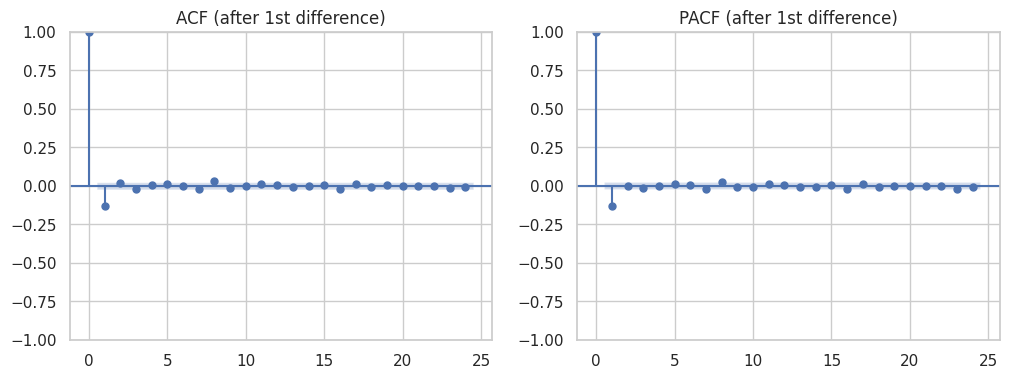

                               SARIMAX Results                                
Dep. Variable:                USD_AUD   No. Observations:                 7576
Model:                 ARIMA(1, 1, 1)   Log Likelihood               28004.487
Date:                Sun, 06 Jul 2025   AIC                         -56002.974
Time:                        09:41:29   BIC                         -55982.177
Sample:                             0   HQIC                        -55995.836
                               - 7576                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1270      0.045     -2.798      0.005      -0.216      -0.038
ma.L1         -0.0045      0.046     -0.098      0.922      -0.094       0.085
sigma2      3.601e-05   9.97e-08    361.098      0.0

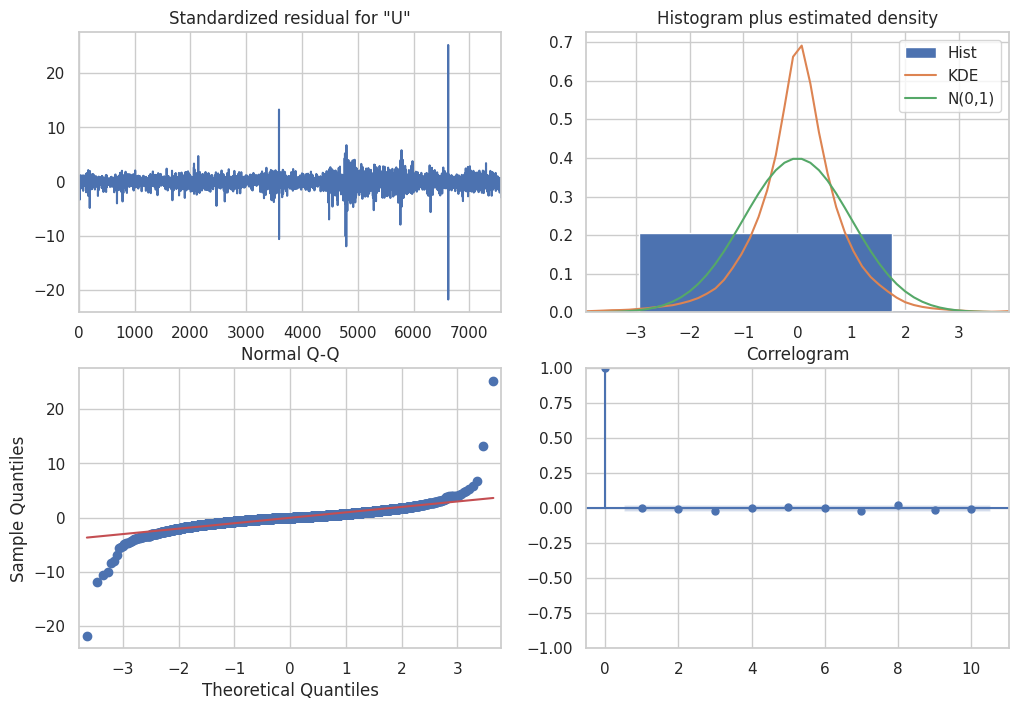

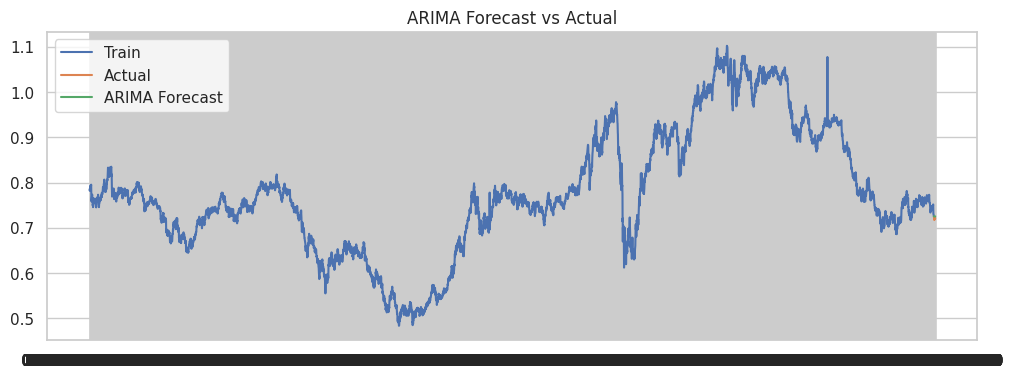

ES params:                      name     param  optimized
smoothing_level     alpha  0.870369       True
smoothing_trend      beta  0.000000       True
smoothing_seasonal  gamma  0.000000       True
initial_level         l.0  0.785795       True
initial_trend         b.0 -0.000009       True
initial_seasons.0     s.0 -0.000757       True
initial_seasons.1     s.1 -0.000714       True
initial_seasons.2     s.2 -0.000735       True
initial_seasons.3     s.3 -0.000475       True
initial_seasons.4     s.4 -0.000515       True
initial_seasons.5     s.5 -0.000703       True
initial_seasons.6     s.6 -0.001015       True
initial_seasons.7     s.7 -0.000731       True
initial_seasons.8     s.8 -0.000885       True
initial_seasons.9     s.9 -0.000744       True
initial_seasons.10   s.10 -0.000677       True
initial_seasons.11   s.11 -0.000954       True


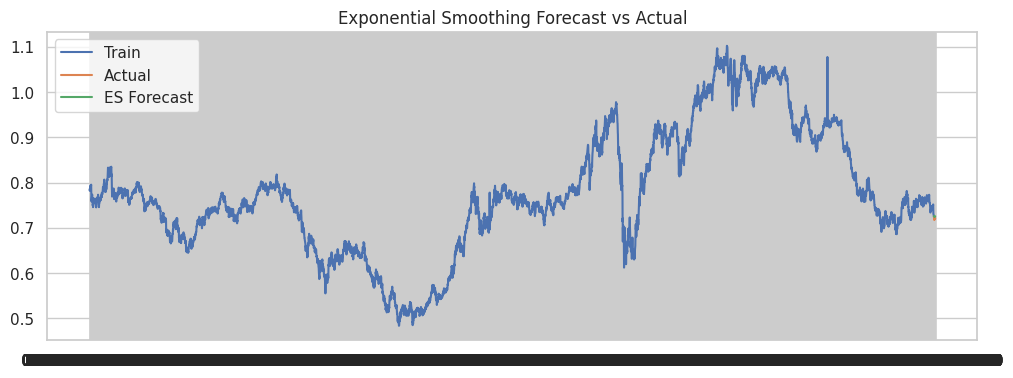


Error metrics on hold‑out period:
ARIMA      | MAE: 0.0048  RMSE: 0.0052  MAPE: nan%
ExpSmooth  | MAE: 0.0045  RMSE: 0.0049  MAPE: nan%


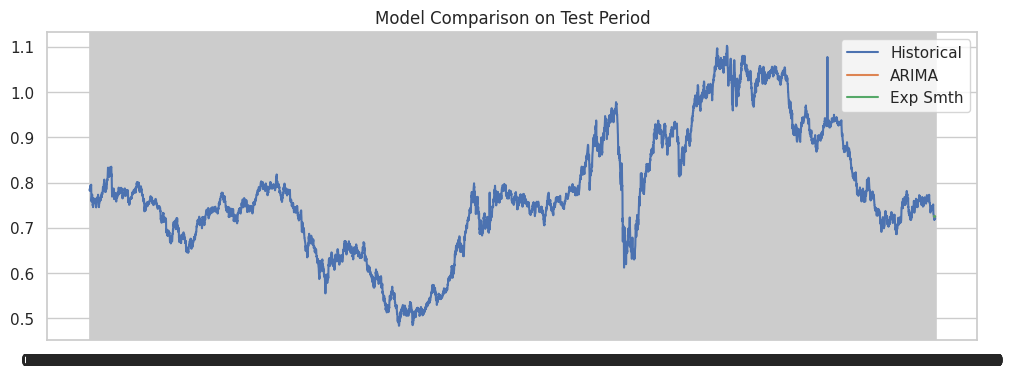


Conclusion: On this dataset, **ExpSmooth** gives the lower RMSE and appears to forecast USD→AUD better over the last 12 periods.


In [ ]:
# ================================================================
# FORECASTING EXCHANGE RATES WITH ARIMA & EXPONENTIAL SMOOTHING
# Dataset : exchange_rate.csv
# Series  : USD ➜ AUD (2nd column)          Date column = index
# ================================================================

# 1. Imports -----------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid")     # Consistent look

# Helper for MAPE
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# ----------------------------------------------------------------
# PART 1 – DATA PREPARATION & EXPLORATION
# ----------------------------------------------------------------
# 1.1 Load data
df = pd.read_csv('exchange_rate.csv', parse_dates=[0], index_col=0)
df.columns = ['USD_AUD']               # rename for convenience
df.head()

# 1.2 Initial exploration
df.plot(figsize=(12,4), title='USD → AUD Exchange Rate')
plt.ylabel('Rate')
plt.show()

# Decompose to eyeball seasonality/trend (optional, needs statsmodels 0.14+)
try:
    from statsmodels.tsa.seasonal import STL
    stl = STL(df['USD_AUD'], period=12).fit()
    stl.plot()
    plt.show()
except Exception as e:
    print("STL plot skipped:", e)

# 1.3 Check & handle missing values / anomalies
print("Missing values:", df.isna().sum().values[0])

# Forward‑fill tiny gaps if any
df = df.ffill()

# Simple anomaly removal example: clip values outside 3σ
mu, sigma = df['USD_AUD'].mean(), df['USD_AUD'].std()
df['USD_AUD'] = df['USD_AUD'].clip(lower=mu-3*sigma, upper=mu+3*sigma)

# ----------------------------------------------------------------
# PART 2 – ARIMA MODEL
# ----------------------------------------------------------------
# Split train / test (e.g. last 12 months as test)
train = df.iloc[:-12]
test  = df.iloc[-12:]

# Differencing order (d): use ADF test for stationarity
adf_stat, pval, *_ = adfuller(train['USD_AUD'])
print(f"ADF p‑value: {pval:.4f} (stationary if < 0.05)")

# 2.1 ACF & PACF → choose p, q
fig, ax = plt.subplots(1,2, figsize=(12,4))
plot_acf(train['USD_AUD'].diff().dropna(), ax=ax[0], lags=24)
plot_pacf(train['USD_AUD'].diff().dropna(), ax=ax[1], lags=24, method='ywm')
ax[0].set_title('ACF (after 1st difference)')
ax[1].set_title('PACF (after 1st difference)')
plt.show()

# Based on plots (modify if needed)
p, d, q = 1, 1, 1

# 2.2 Fit ARIMA
arima = ARIMA(train['USD_AUD'], order=(p,d,q)).fit()
print(arima.summary())

# 2.3 Diagnostics
arima.plot_diagnostics(figsize=(12,8))
plt.show()

# 2.4 Forecast
n_forecast = len(test)
arima_pred = arima.forecast(steps=n_forecast)
plt.figure(figsize=(12,4))
plt.plot(train.index, train['USD_AUD'], label='Train')
plt.plot(test.index,  test['USD_AUD'],  label='Actual')
plt.plot(test.index,  arima_pred,       label='ARIMA Forecast')
plt.title('ARIMA Forecast vs Actual')
plt.legend(); plt.show()

# ----------------------------------------------------------------
# PART 3 – EXPONENTIAL SMOOTHING
# ----------------------------------------------------------------
# Choose model: Use STL insight or auto‑trial
# Here we use Holt‑Winters additive seasonality (monthly = 12)
es = ExponentialSmoothing(train['USD_AUD'],
                          trend='add',
                          seasonal='add',
                          seasonal_periods=12).fit(optimized=True)

print("ES params:", es.params_formatted)

# Forecast
es_pred = es.forecast(n_forecast)

plt.figure(figsize=(12,4))
plt.plot(train.index, train['USD_AUD'], label='Train')
plt.plot(test.index,  test['USD_AUD'],  label='Actual')
plt.plot(test.index,  es_pred,          label='ES Forecast')
plt.title('Exponential Smoothing Forecast vs Actual')
plt.legend(); plt.show()

# ----------------------------------------------------------------
# PART 4 – EVALUATION & COMPARISON
# ----------------------------------------------------------------
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

def evaluate(y_true, y_pred, name):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))   # <- manual sqrt
    mape_v = mape(y_true, y_pred)
    print(f"{name:<10} | MAE: {mae:.4f}  RMSE: {rmse:.4f}  MAPE: {mape_v:.2f}%")
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape_v}

print("\nError metrics on hold‑out period:")
arima_scores = evaluate(test['USD_AUD'], arima_pred, 'ARIMA')
es_scores    = evaluate(test['USD_AUD'], es_pred,    'ExpSmooth')

# Combine forecasts visually
plt.figure(figsize=(12,4))
plt.plot(df.index, df['USD_AUD'], label='Historical')
plt.plot(test.index, arima_pred, label='ARIMA')
plt.plot(test.index, es_pred,    label='Exp Smth')
plt.title('Model Comparison on Test Period')
plt.legend(); plt.show()

# 4.3 Conclusion (print quick text)
better = 'ARIMA' if arima_scores['RMSE'] < es_scores['RMSE'] else 'ExpSmooth'
print(f"\nConclusion: On this dataset, **{better}** gives the lower RMSE "
      f"and appears to forecast USD→AUD better over the last {n_forecast} periods.")
